In [16]:
# source proxypicker-env/bin/activate
# 
# cd /Users/jamaman/Documents/GitHub/ProxyPicker/images
# 
# python3 -m http.server
# 

In [17]:
%%capture --no-stderr
%pip install -U  langgraph

In [18]:
import os, getpass
import operator
import base64

import httpx
from typing import Optional
from typing_extensions import Annotated, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from IPython.display import Image
from langgraph.graph import END, StateGraph, START
from langchain_openai import ChatOpenAI
from typing import List


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [19]:
proxy_picker_llm = ChatOpenAI(model="gpt-4o-2024-11-20", temperature=0.1, base_url="https://reverse.onechats.top/v1")

In [20]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "proxy_picker"

In [21]:
interaction_parsing_prompt = """You are an interaction parser. Please analyze and interpret the haptic feedback a user should perceive while interacting with the virtual object during the given task.
 
 Given task: {given_task}
 
 Provide a detailed analysis of the following aspects based on the given task and the provided picture of the virtual object:
 
 1. Interacted Virtual Object
 2. Contacted Part
 3. Involved Interaction
 4. External Forces"""

object_fetching_prompt = """You are an object fetcher. Please carefully inspect and list all visible physical objects in the image(s) of surrounding objects regarding their names and position, ensuring that no object is overlooked."""

attribute_extraction_prompt = """You are an attribute extracter. Please describe a specified physical object in detail regarding its characteristics relevant to haptic feedback.

Specified object: {target_object}
Position in image: {object_position}

Your description should focus on the following criteria:

1. Inertia: 
    * Describe the object's weight and how it feels when held
    * Comment on whether the weight distribution is balanced or uneven
    
2. Interactivity:
    * Identify the ways in which the object can be interacted with (e.g., pressing, rotating, sliding, extending, squeezing)
    * Describe any movable or functional parts, such as buttons, hinges, sliders, or extendable sections.

3. Outline:
    * Provide a description of the object's shape, size, and dimensions.
    * Note any prominent features, edges, curves, or contact surfaces that would be relevant for contacting or interacting with the object.

4. Texture:
    * Describe the surface texture of the object, including whether it is smooth, rough, grainy, or patterned.
    * Note any variations in texture across different parts of the object.
    
5. Hardness:
    * Note any areas of the object that deform under pressure or retain their shape.
    * Comment on whether the hardness is uniform throughout the object or varies in different sections"""

interaction_exploring_prompt = """You are an interaction explorer. Please come up with the most suitable and plausible way of utilizing {target_object} in the given picture ({object_position}) as a haptic proxy of {virtual_object} in virtual reality. When thinking about the interaction possibility, consider the following information carefully, and comprehensively explain how users interact with {target_object} in reality to trigger expected haptic feedbacks.

The interaction between users and {virtual_object} in VR: {given_task}

Here is the parsed detail of the interaction in VR: {parsed_interaction}

Here is the extracted attribute of {target_object}: {extracted_attribute}"""

candidate_evaluation_prompt = """You are a haptic proxy evaluator. Your role is to access the suitability of physical objects' interaction possibilities as a haptic proxy for performing the given task in VR. Your evaluation will focus on how well these interaction possibilities simulate the ideal haptic feedback required for the task.

Given task in VR: {given_task}
Parsed interaction: {parsed_interaction}

Please evaluate each physical object's interaction possibility based on the criteria of inertia, interactivity, outline, texture, and hardness. 

Inertia: How closely the physical object's inertia matches that of the virtual object.
Interactivity: How well the physical object facilitates the specific types of interactions required in the virtual environment (e.g., pressing, rotating, sliding, extending).
Outline: The closely the physical shape and size of the contact parts resemble the corresponding parts of the virtual object that users would contact and/or interact with.
Texture: How well the surface texture of the contact parts mimics the corresponding parts of the virtual object that users would contact and/or interact with.
Hardness: How closely the material stiffness of the contact or flexible parts corresponds to interacting with the virtual object.

Rate each criterion for the physical object's interaction possibility on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match. 

Provide a grouped justification for the ratings of each physical object, addressing all criteria collectively for the interaction possibilities associated with the object.

Interaction possibilities to be evaluated: \n\n{interaction_possibilities}"""

# weighted_average_prompt = """You are a weighted average calculator. Please calculate each physical object's weighted average (inertia, interactivity, outline, texture, hardness) with respective criteria weights.
# 
# Criteria weights: {criteria_weights}
# 
# Ratings of physical objects: \n\n {ratings}"""


In [22]:
physical_url = "http://localhost:8000/p1.jpg"
image_data = base64.b64encode(httpx.get(physical_url).content).decode("utf-8")
prefab_url = "http://localhost:8000/f1.jpg"
prefab_data = base64.b64encode(httpx.get(prefab_url).content).decode("utf-8")

In [23]:
class Proxy(BaseModel):
    name: str = Field(description="A clear and concise name or description of the object")
    position: str = Field(description="The object's location and relative placement within the image(s)")
    
    inertia: Optional[str] = Field(None, description="Detailed description of the inertia based on the criteria")
    interactivity: Optional[str] = Field(None, description="Detailed description of the interactivity based on the criteria")
    outline: Optional[str] = Field(None, description="Detailed description of the outline based on the criteria")
    texture: Optional[str] = Field(None, description="Detailed description of the texture based on the criteria")
    hardness: Optional[str] = Field(None, description="Detailed description of the hardness based on the criteria")
    
    interaction_possibility: Optional[str] = Field(None, description="Comprehensive explanation of the most suitable way to utilize this physical object as a haptic proxy for the virtual object")
    
    @property
    def attribute(self) -> str:
        return f"Haptic Proxy: {self.name}\nPosition: {self.position}\nInertia: {self.inertia}\nInteractivity: {self.interactivity}\nOutline: {self.outline}\nTexture: {self.texture}\nHardness: {self.hardness}"
    
    @property
    def evaluation(self) -> str:
        return f"Physical Object: {self.name}\nPosition in Given Picture: {self.position}\nInteraction Possibility: {self.interaction_possibility}"
    
class ProxyCandidates(BaseModel):
    proxies: List[Proxy] = Field(description="Comprehensive list of physical objects in the given picture")

class EvaluatedCandidate(BaseModel):
    name: str = Field(description="The name of the physical object")
    position: str = Field(description="The relative positions of the physical object in the given picture")   
    interaction_possibility: str = Field(description="Comprehensive explanation of the most suitable way to utilize this physical object as a haptic proxy for the virtual object")
    
    rating_inertia: int = Field(None, description="The rating of inertia on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match")
    rating_interactivity: int = Field(None, description="The rating of interactivity on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match")
    rating_outline: int = Field(None, description="The rating of outline on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match")
    rating_texture: int = Field(None, description="The rating of texture on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match")
    rating_hardness: int = Field(None, description="The rating of hardness on a scale of 1 to 10 points, where 1 indicates poor match and 10 indicates excellent match")
    justification: str = Field(None, description="The justification for the ratings of five criteria")
    
    weighted_average: float = Field(None, description="The weighted average of all five ratings")
    
    @property
    def ratings(self) -> str:
        return f"Physical Object: {self.name}\nPosition in Given Picture: {self.position}\nInteraction Possibility: {self.interaction_possibility}\nRating of Inertia: {self.rating_inertia}\nRating of Interactivity: {self.rating_interactivity}\nRating of Outline: {self.rating_outline}\nRating of Texture: {self.rating_texture}\nRating of Hardness: {self.rating_hardness}"
    
class EvaluatedCandidates(BaseModel):
    candidates: List[EvaluatedCandidate] = Field(description="List of evaluated candidates with rated inertia, interactivity, outline, texture and hardness")
    
class TopCandidates(BaseModel):
    top_candidates: List[EvaluatedCandidate] = Field(description="List of top 3 candidates with highest weighted average")

class Prefab(BaseModel):
    interacted_virtual_object: str = Field(description="Identify what virtual object the user will grasp and/or interact with to perform the given task")
    contacted_part: str = Field(description="Describe which part(s) of the virtual object the user will primarily contact during the interaction")
    involved_interaction: str = Field(description="Describe how the virtual object will be interacted by the user.")
    external_force: str = Field(description="Describe what types of external forces the user might encounter during the interaction")
    
    @property
    def review(self) -> str:
        return f"The given task is parsed as follow in terms of what haptic feedback a user should perceive while interacting with the virtual object in virtual reality:\nVirtual Object: {self.interacted_virtual_object}\nForm: {self.contacted_part}\nInteraction: {self.involved_interaction}\nExternal Forces: {self.external_force}"
    
class OverallState(TypedDict):
    given_task: str
    
    involvement: str
    transportability: str
    reconfiguration: str
    
    score_inertia: int
    score_interaction: int
    score_outline: int
    score_texture: int
    score_hardness: int

    proxies: List[Proxy]
    proxy_candidates_complete: Annotated[list, operator.add]
    prefab: Prefab
    weight_dict: dict
    evaluated_candidates: List[EvaluatedCandidate]
    
class InspectState(TypedDict):
    target_object: Proxy
    given_task: str
    prefab: Prefab
    proxy_candidates_complete: List[Proxy]
    
class InspectOutputState(TypedDict):
    proxy_candidates_complete: List[Proxy]


In [24]:
def weight_calculator (state: OverallState):
    attributes = ["inertia", "interactivity", "outline", "texture", "hardness"]
    ratings = [state["score_inertia"], state["score_interaction"], state["score_outline"], state["score_texture"], state["score_hardness"]]
    weights = [rating / sum(ratings) for rating in ratings]
    
    weighted_attributes = dict(zip(attributes, weights))
    return {"weight_dict": weighted_attributes}

def object_fetcher (state: OverallState):
    prompt_system = SystemMessage(content=[object_fetching_prompt])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(ProxyCandidates).invoke(messages)
    return {"proxies": response.proxies} #messages should also be a list : "messages": [response]    
    
def interaction_parser (state: OverallState):
    prompt_system = SystemMessage(content=[interaction_parsing_prompt.format(given_task=state["given_task"])])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(Prefab).invoke(messages)
    return {"prefab": response}

def candidate_evaluator (state: OverallState):
    possibilities = "\n\n".join(p.evaluation for p in state["proxy_candidates_complete"])
    prompt_system = SystemMessage(content=[candidate_evaluation_prompt.format(given_task=state["given_task"], parsed_interaction=state["prefab"].review, interaction_possibilities=possibilities)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(EvaluatedCandidates).invoke(messages)
    return {"evaluated_candidates": response.candidates}

# def proxy_picker (state: OverallState):
#     ratings = "\n\n".join(r.ratings for r in state["evaluated_candidates"])
#     prompt_system = SystemMessage(content=[weighted_average_prompt.format(criteria_weights=state["weight_dict"], ratings=ratings)])
#     prompt_human = HumanMessage(content="Please return the top 3 candidates with highest total scores. Sort them in descending order of total score.")
#     messages = [prompt_system, prompt_human]
#     response = proxy_picker_llm_tools.with_structured_output(TopCandidates).invoke(messages)
#     return {"top_candidates": response.top_candidates}

In [25]:
def continue_to_attrbute(state: OverallState):
    return [Send("proxy_inspector", {"target_object": t, "given_task": state["given_task"], "prefab": state["prefab"]}) for t in state["proxies"]]

def attribute_extracter (state: InspectState):
    prompt_system = SystemMessage(content=[attribute_extraction_prompt.format(target_object=state["target_object"].name, object_position=state["target_object"].position)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(Proxy).invoke(messages)
    return {"target_object": response}

def interaction_explorer(state: InspectState):
    prompt_system = SystemMessage(content=[interaction_exploring_prompt.format(target_object=state["target_object"].name, object_position=state["target_object"].position, given_task=state["given_task"], virtual_object=state["prefab"].interacted_virtual_object, parsed_interaction=state["prefab"].review, extracted_attribute=state["target_object"].attribute)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(Proxy).invoke(messages)
    return {"proxy_candidates_complete": [response]}

/var/folders/dm/mwc26gqj5kvbzk2nffzh__5m0000gn/T/ipykernel_55434/244596100.py:1: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  builder = StateGraph(input=InspectState, output=InspectOutputState)


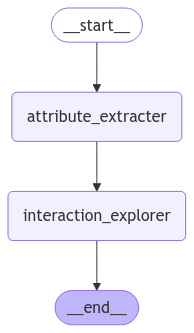

In [26]:
builder = StateGraph(input=InspectState, output=InspectOutputState)
builder.add_node("attribute_extracter", attribute_extracter)
builder.add_node("interaction_explorer", interaction_explorer)

builder.add_edge(START, "attribute_extracter")
builder.add_edge("attribute_extracter", "interaction_explorer")
builder.add_edge("interaction_explorer", END)

proxy_inspector = builder.compile()
Image(proxy_inspector.get_graph().draw_mermaid_png())

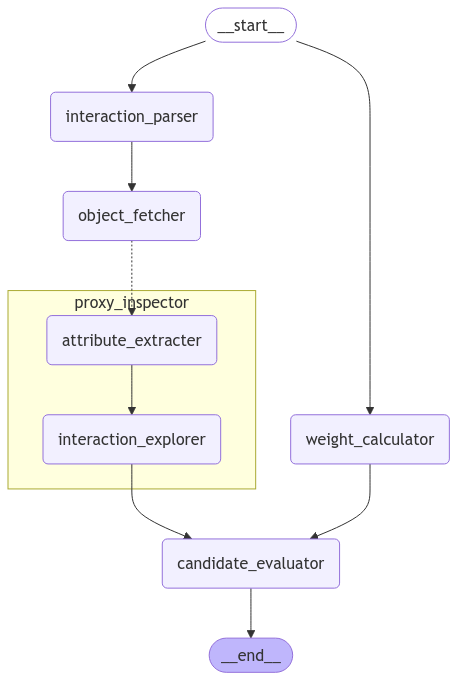

In [27]:
graph = StateGraph(OverallState)
graph.add_node("weight_calculator", weight_calculator)
graph.add_node("interaction_parser", interaction_parser)
graph.add_node("object_fetcher", object_fetcher)
graph.add_node("proxy_inspector", proxy_inspector)
graph.add_node("candidate_evaluator", candidate_evaluator)
# graph.add_node("proxy_picker", proxy_picker)
# graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "interaction_parser")
graph.add_edge(START, "weight_calculator")
graph.add_edge("interaction_parser", "object_fetcher")
graph.add_conditional_edges("object_fetcher", continue_to_attrbute, ["proxy_inspector"])
graph.add_edge(["proxy_inspector", "weight_calculator"], "candidate_evaluator")
graph.add_edge("candidate_evaluator", END)
# graph.add_edge("candidate_evaluator", "proxy_picker")
# graph.add_conditional_edges("proxy_picker", tools_condition,)
# graph.add_edge("tools", "proxy_picker")

proxy_picker = graph.compile()
display(Image(proxy_picker.get_graph(xray=1).draw_mermaid_png()))
# Image(proxy_picker.get_graph()(xray=1).draw_mermaid_png())

In [28]:
for s in proxy_picker.stream({"given_task": "scrutinise using binoculars", "involvement": "grasp", "transportability": "stationary", "reconfiguration": "rigid", "score_inertia": 3, "score_interaction": 0, "score_outline": 5, "score_texture": 3, "score_hardness": 2}, stream_mode="values"):
    # print(s)
    weight_dict = s.get('weight_dict', '')
    evaluated_candidates = s.get('evaluated_candidates', '')
    if evaluated_candidates and weight_dict:
        for evaluated_candidate in evaluated_candidates:
            evaluated_candidate.weighted_average = (
                evaluated_candidate.rating_inertia * weight_dict["inertia"] + 
                evaluated_candidate.rating_interactivity * weight_dict["interactivity"] +
                evaluated_candidate.rating_outline * weight_dict["outline"] + 
                evaluated_candidate.rating_texture * weight_dict["texture"] +
                evaluated_candidate.rating_hardness * weight_dict["hardness"]
            )

        sorted_candidates = sorted(
            evaluated_candidates, key=lambda candidate: candidate.weighted_average, reverse=True
        )

        print(sorted_candidates[:3])

[EvaluatedCandidate(name='controller', position='bottom left', interaction_possibility="The controller is the best match as it can be held in both hands, has a similar weight and hardness, and its shape somewhat resembles the binoculars' grip.", rating_inertia=8, rating_interactivity=7, rating_outline=8, rating_texture=6, rating_hardness=7, justification=None, weighted_average=7.384615384615385), EvaluatedCandidate(name='headphones', position='top left', interaction_possibility="The headphones can be held in both hands to simulate the binoculars' grip, but the lack of a central hinge and the bulkier ear cups make it less ideal.", rating_inertia=6, rating_interactivity=3, rating_outline=5, rating_texture=7, rating_hardness=6, justification=None, weighted_average=5.846153846153847), EvaluatedCandidate(name='duck lamp', position='middle right', interaction_possibility="The duck lamp is too bulky and does not replicate the binoculars' dual-hand interaction or shape.", rating_inertia=5, rat

In [29]:
# proxy_picker_llm.invoke("Hi")

In [30]:
# for event in proxy_picker.stream({"given_task": "scrutinise using binoculars", "involvement": "grasp", "transportability": "stationary", "reconfiguration": "rigid", "score_inertia": 3, "score_interaction": 0, "score_outline": 5, "score_texture": 3, "score_hardness": 2}): #stream_mode="values"
#     # weight_dict = event.get('weight_dict', '')
#     # evaluated_candidates = event.get('evaluated_candidates', '')
#     print(event)
#     # print("dict:" + str(weight_dict))
#     # print(evaluated_candidates)
#     # if evaluated_candidates and weight_dict:
#     #     for evaluated_candidate in evaluated_candidates:
#     #         evaluated_candidate.weighted_average = (
#     #             evaluated_candidate.rating_inertia * weight_dict["inertia"] + 
#     #             evaluated_candidate.rating_interactivity * weight_dict["interactivity"] +
#     #             evaluated_candidate.rating_outline * weight_dict["outline"] + 
#     #             evaluated_candidate.rating_texture * weight_dict["texture"] +
#     #             evaluated_candidate.rating_hardness * weight_dict["hardness"]
#     #         )
#     # 
#     #     sorted_candidates = sorted(
#     #         evaluated_candidates, key=lambda candidate: candidate.weighted_average, reverse=True
#     #     )
#     # 
#     #     print(sorted_candidates[:3])